In [1]:
library("DESeq2")
library("biomaRt")
dir_counts <- "~/ABABhwk/Unit2-RNAseq/data/htseq_out/day5"
counts_files <- list.files(dir_counts)
samplesInfo <- as.data.frame(matrix(ncol=2, nrow=length(counts_files)))  
samplesInfo$samplename <- counts_files  
samplesInfo$filename <- counts_files  
samplesInfo$group <- c("mock", "ZIKV", "mock", "ZIKV", "mock", "ZIKV") 
#Remove the blank columns
samplesInfo <- samplesInfo[,-c(1:2)]
dds1 <- DESeqDataSetFromHTSeqCount(sampleTable = samplesInfo, 
                                           directory = dir_counts, 
                                           design = ~ group)
#### Run the main DESeq normalization and analysis function
dds1_deseq <- DESeq(dds1)
res <- results(dds1_deseq, contrast=c("group", "ZIKV", "mock"))
summary(res)
resSorted <- res[order(res$padj),]
# EMSEMBL ids 
bm <- useMart(biomart = "ensembl")
bm <- useDataset(dataset = "hsapiens_gene_ensembl", mart = bm)
ens2genesymbol <- getBM(mart = bm, attributes = c('ensembl_gene_id', 'external_gene_name'))


Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, table, tapply, union, unique,
    unsplit, which, which.max, which


out of 37609 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 461, 1.2%
LFC < 0 (down)     : 476, 1.3%
outliers [1]       : 9, 0.024%
low counts [2]     : 20516, 55%
(mean count < 24)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



## Installing libraries
```
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install("org.Hs.eg.db", version = "3.8")
BiocManager::install("clusterProfiler", version = "3.8")
```

In [2]:
library(clusterProfiler)
library(org.Hs.eg.db)


clusterProfiler v3.10.0  For help: https://guangchuangyu.github.io/software/clusterProfiler

If you use clusterProfiler in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Yanyan Han, Qing-Yu He. clusterProfiler: an R package for comparing biological themes among gene clusters. OMICS: A Journal of Integrative Biology. 2012, 16(5):284-287.

Attaching package: ‘clusterProfiler’

The following object is masked from ‘package:DelayedArray’:

    simplify

Loading required package: AnnotationDbi



## Volcano Plot
Let's redo the volcano plot we had used before. 

This time however let's highlight the differentially expressed genes with a **fold change >= 2** and **p-value <= 0.01**.

Let's remove NAs from resSorted$padj

In [3]:
resFilteredSorted <- resSorted[complete.cases(resSorted$padj),]
dim(resFilteredSorted)

[1] 17084     6

Let's create a column "selected" an set value to **TRUE** or **FALSE** based on whether they satisfy our conditions.

In [4]:
resFilteredSorted[,"selected"] <- FALSE
resFilteredSorted[resFilteredSorted$padj <= 0.01 & abs(resFilteredSorted$log2FoldChange) >= 1, "selected"] <- TRUE

Let's now plot the volcano plot. log2Foldchange on the xaxis and -log10(padj) on yaxis.

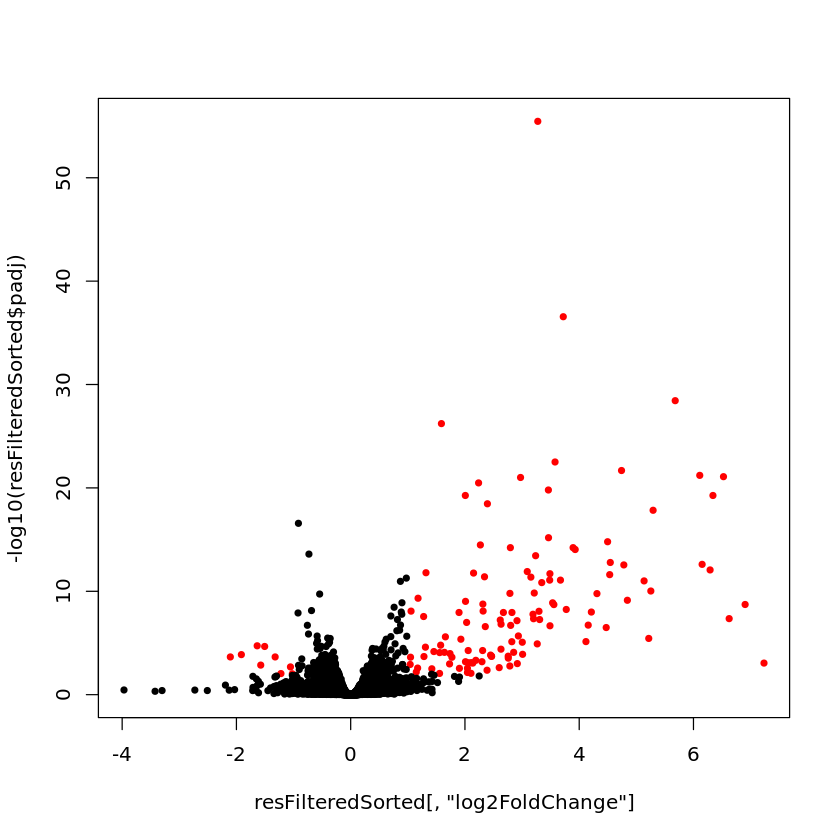

In [5]:
plot(resFilteredSorted[,"log2FoldChange"], -log10(resFilteredSorted$padj), col=as.factor(resFilteredSorted$selected), pch=20)

Let's try and plot the text for each gene. We've already retrieved the symbol for the ENSEMBL id using the *getBM()* function in the bioMart package.

In [6]:
# Select rows from resFilteredSort that match out conditions.
df.selected <- resFilteredSorted[resFilteredSorted$padj <= 0.01 & abs(resFilteredSorted$log2FoldChange) >= 1,]
# Loop over ens2genesymbol dataframe that was created before to get the gene name for each ENSEMBL ID
df.labels <- sapply(rownames(df.selected), function(x){
    ens2genesymbol[ens2genesymbol["ensembl_gene_id"]==x,"external_gene_name"]
})

Now let's plot!

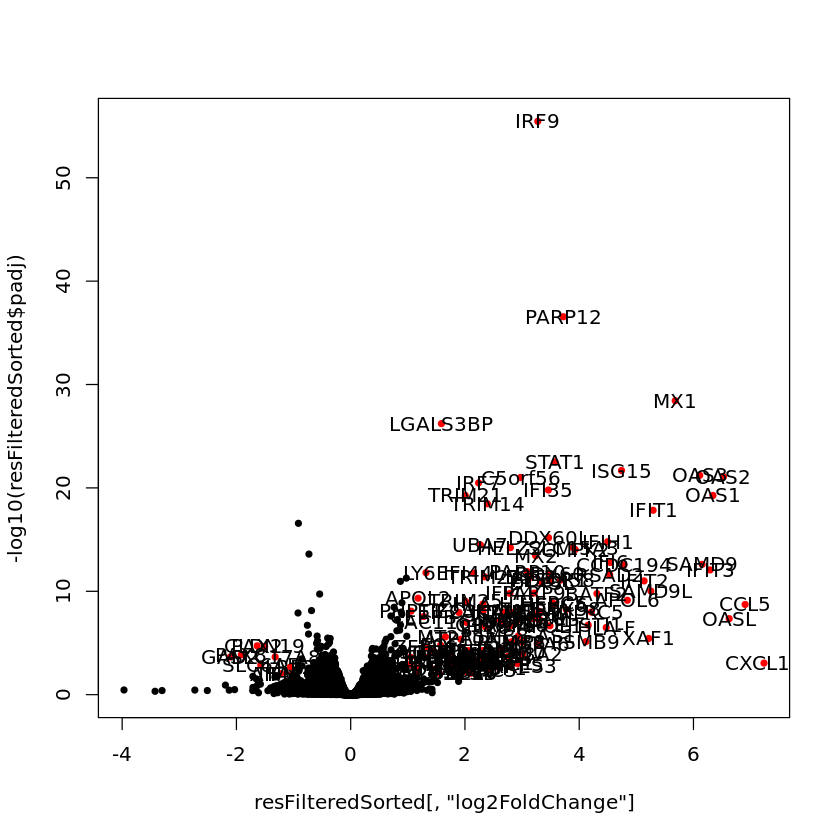

In [7]:
plot(resFilteredSorted[,"log2FoldChange"], -log10(resFilteredSorted$padj), col=as.factor(resFilteredSorted$selected), pch=20)
text(df.selected[,"log2FoldChange"], -log10(df.selected$padj), labels = df.labels)

Let's now create a heatmap showing the groups using the *pheatmap()* function.

In [8]:
library(pheatmap)
df <- data.frame(colData(rld)[,"group"])
rownames(df) <- rownames(colData(rld))
colnames(df) <- c("group")

ngenes <- 40
deg <- rownames(resSorted)[1:ngenes]
mat <- assay(rld)[deg,]
mat <- mat - rowMeans(mat)
rownames(mat) <- sapply(rownames(resSorted)[1:ngenes], function(x){
    return(ens2genesymbol[ens2genesymbol[,"ensembl_gene_id"]==x,"external_gene_name"]);
})

pheatmap(mat,
        annotation_col = df,
        cluster_cols = T,
        cluster_rows=F)

ERROR: Error in colData(rld): object 'rld' not found


## Go enrichment

Let's now map the ENSEMBL ids to GO ids using the *bitr()* function.

In [9]:
head(resFilteredSorted)

log2 fold change (MLE): group ZIKV vs mock 
Wald test p-value: group ZIKV vs mock 
DataFrame with 6 rows and 7 columns
                        baseMean   log2FoldChange             lfcSE
                       <numeric>        <numeric>         <numeric>
ENSG00000213928 512.187721168106 3.27507531743713 0.199747474400547
ENSG00000059378 336.458301796665 3.72099714418401 0.276732653993865
ENSG00000157601 4008.96259771101 5.68040787674336 0.475308620229342
ENSG00000108679  5768.8841282551 1.58820729622307 0.138176747460854
ENSG00000115415  14617.158612877 3.57704283976823 0.333979738711162
ENSG00000187608 3876.78300136491 4.74071973993298 0.450824815194356
                            stat               pvalue                 padj
                       <numeric>            <numeric>            <numeric>
ENSG00000213928 16.3960787352421  2.0398723786704e-60 3.48491797172052e-56
ENSG00000059378 13.4461802410441 3.24191545350508e-41 2.76924418038404e-37
ENSG00000157601 11.9509885471938 6.41

In [10]:
gomap <- bitr(rownames(resFilteredSorted), "ENSEMBL", "GO", org.Hs.eg.db, drop = TRUE)

'select()' returned 1:many mapping between keys and columns
Warning message in bitr(rownames(resFilteredSorted), "ENSEMBL", "GO", org.Hs.eg.db, :
“20.9% of input gene IDs are fail to map...”

In [11]:
nrow(bitr(rownames(resFilteredSorted), "ENSEMBL", "ENSEMBLPROT", org.Hs.eg.db, drop = TRUE))

'select()' returned 1:many mapping between keys and columns
Warning message in bitr(rownames(resFilteredSorted), "ENSEMBL", "ENSEMBLPROT", org.Hs.eg.db, :
“76.42% of input gene IDs are fail to map...”

[1] 16090

Let's now select the unique EMSEMBL and GO id pairs from the Molecular Function(MF) domain.

In [12]:
gomap.f <- gomap[gomap$ONTOLOGY=="MF",]
gomap.f <- unique(gomap.f[,c("ENSEMBL", "GO")])

In [13]:
head(gomap.f)

,ENSEMBL,GO
1,ENSG00000213928,GO:0000978
2,ENSG00000213928,GO:0000981
5,ENSG00000213928,GO:0003700
6,ENSG00000213928,GO:0005515
18,ENSG00000059378,GO:0003723
19,ENSG00000059378,GO:0003950


Let's now get the human readable descriptions of the GO ids.

In [14]:
gomap.descriptions <- go2term(unique(gomap.f$GO))
head(gomap.descriptions)

go_id,Term
GO:0044183,protein binding involved in protein folding
GO:0051082,unfolded protein binding
GO:0003756,protein disulfide isomerase activity
GO:0015036,disulfide oxidoreductase activity
GO:0000010,trans-hexaprenyltranstransferase activity
GO:0000014,single-stranded DNA endodeoxyribonuclease activity


Let's now create a new column, "GO_TERM" in the gomap.f dataframe and add the description there.

In [15]:
gomap.f$GO_TERM <- sapply(gomap.f$GO, function(x){
    return(gomap.descriptions[gomap.descriptions$go_id==x,"Term"]);
})

In [16]:
head(gomap.f)

,ENSEMBL,GO,GO_TERM
1,ENSG00000213928,GO:0000978,RNA polymerase II proximal promoter sequence-specific DNA binding
2,ENSG00000213928,GO:0000981,"DNA-binding transcription factor activity, RNA polymerase II-specific"
5,ENSG00000213928,GO:0003700,DNA-binding transcription factor activity
6,ENSG00000213928,GO:0005515,protein binding
18,ENSG00000059378,GO:0003723,RNA binding
19,ENSG00000059378,GO:0003950,NAD+ ADP-ribosyltransferase activity


Let's get a table of the counts of each GO term

In [17]:
gomap.f.table <- table(gomap.f$GO_TERM)
# Sort table by count
gomap.f.table <- gomap.f.table[order(gomap.f.table, decreasing=TRUE)]

Let's make a piechart of the top 20 GO terms using the table!

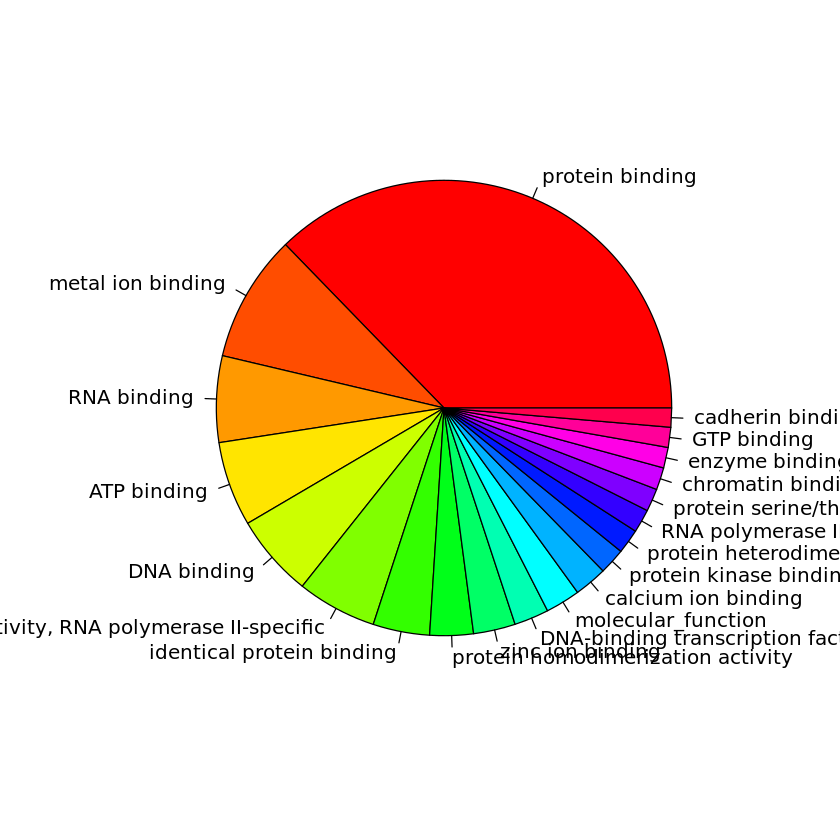

In [18]:
# raindow is just a colorscheme.
pie(gomap.f.table[1:20], col = rainbow(20))

### The piechart above is NOT an enrichment.

It simply tells us how the differentially expressed genes relate to ontology terms.

Let's now try and do a very basic **GO enrichment analysis**. 

We now have to pick a set of "background genes" to compare our differentially expresssed genes against. Let's first plot the mean normalized counts for each gene.

In [19]:
head(resSorted)

log2 fold change (MLE): group ZIKV vs mock 
Wald test p-value: group ZIKV vs mock 
DataFrame with 6 rows and 6 columns
                        baseMean   log2FoldChange             lfcSE
                       <numeric>        <numeric>         <numeric>
ENSG00000213928 512.187721168106 3.27507531743713 0.199747474400547
ENSG00000059378 336.458301796665 3.72099714418401 0.276732653993865
ENSG00000157601 4008.96259771101 5.68040787674336 0.475308620229342
ENSG00000108679  5768.8841282551 1.58820729622307 0.138176747460854
ENSG00000115415  14617.158612877 3.57704283976823 0.333979738711162
ENSG00000187608 3876.78300136491 4.74071973993298 0.450824815194356
                            stat               pvalue                 padj
                       <numeric>            <numeric>            <numeric>
ENSG00000213928 16.3960787352421  2.0398723786704e-60 3.48491797172052e-56
ENSG00000059378 13.4461802410441 3.24191545350508e-41 2.76924418038404e-37
ENSG00000157601 11.9509885471938 6.41

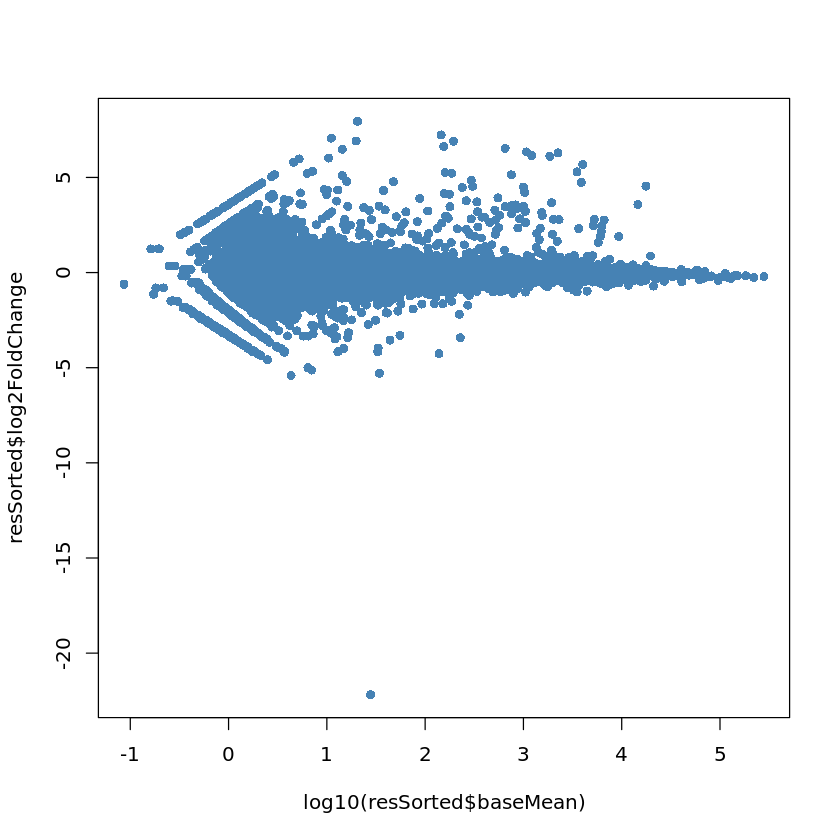

In [20]:
plot(log10(resSorted$baseMean), resSorted$log2FoldChange, pch=16, col="steelblue")

Let's now throw out all genes with mean normalized count <= 10 and redo the above plot.

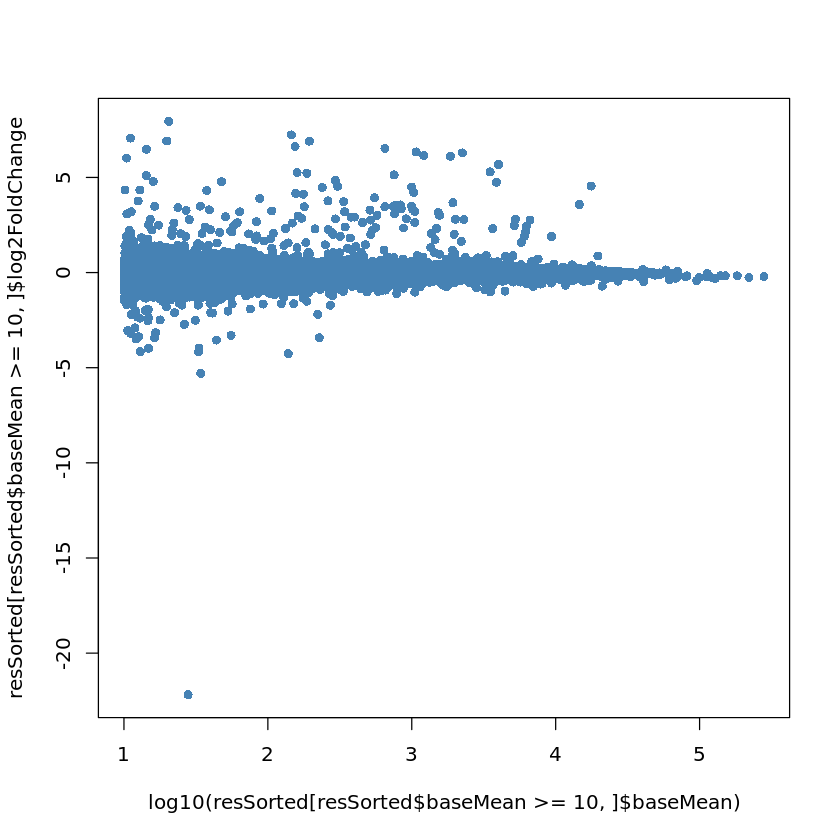

In [21]:
plot(log10(resSorted[resSorted$baseMean >= 10,]$baseMean), resSorted[resSorted$baseMean >= 10,]$log2FoldChange, pch=16, col=c("steelblue"))

To quickly do a spot check let's pull out a gene with normalized mean count < 10 and see which tissues it is expressed in on the [GTEx](https://gtexportal.org/home/) database.

In [22]:
resSorted[resSorted$baseMean <10,]

log2 fold change (MLE): group ZIKV vs mock 
Wald test p-value: group ZIKV vs mock 
DataFrame with 38957 rows and 6 columns
                         baseMean     log2FoldChange             lfcSE
                        <numeric>          <numeric>         <numeric>
ENSG00000000005  6.33853718932102 -0.283335278999331 0.840671932155369
ENSG00000000971   6.6684646392983 -0.521457576887272  1.06293637212725
ENSG00000002726 0.390659252409036   2.21876321991154  3.83230881947248
ENSG00000002745  7.62980062812403  -1.07192475973923 0.829272378047164
ENSG00000004809                 0                 NA                NA
...                           ...                ...               ...
ENSG00000285989                 0                 NA                NA
ENSG00000285990 0.597527409245946  -1.06736053670443  3.37327179989494
ENSG00000285991  2.34943851238369   1.87259707649729  1.66805217925569
ENSG00000285992                 0                 NA                NA
ENSG00000285993          

Let's do the inverse now. This data was obtained by sequencing cerebral organoids that  recapitulate fetal brain development. Let's look at some differentially expressed genes in the brain on GTEx and then see how they're expressed in this data.

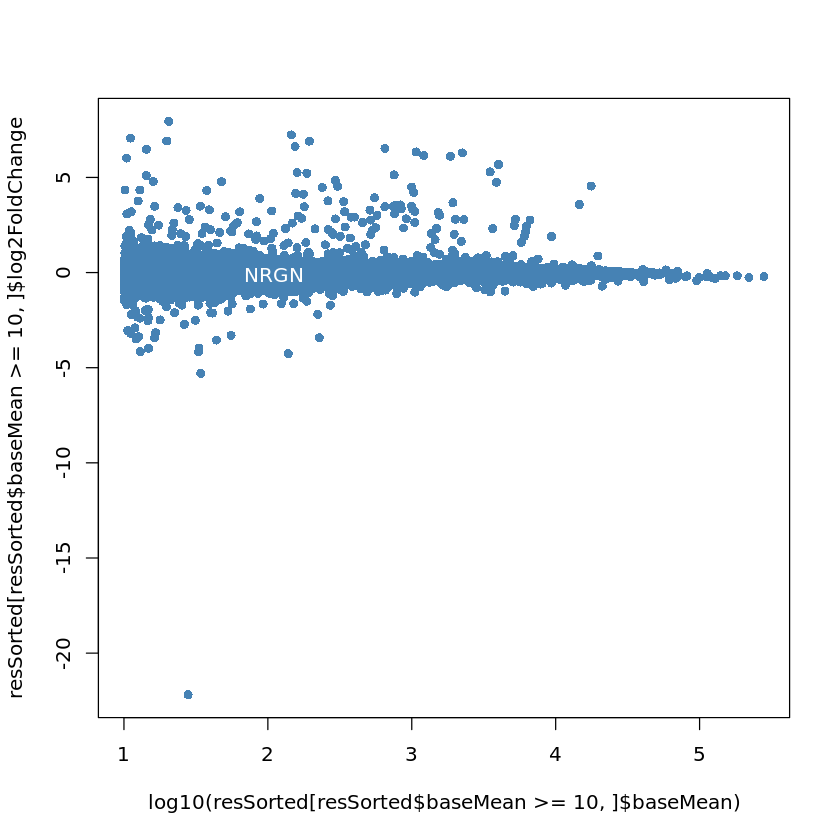

In [23]:
plot(log10(resSorted[resSorted$baseMean >= 10,]$baseMean), resSorted[resSorted$baseMean >= 10,]$log2FoldChange, pch=16, col=c("steelblue"))
text(log10(resSorted["ENSG00000154146",]$baseMean), resSorted["ENSG00000154146",]$log2FoldChange, labels = c("NRGN"), col="white")

To generate *resFilteredSorted* we removed any genes for which padj was NA. 

Mote details on why padj might be set to NA are here in the [vignette](https://www.bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html).

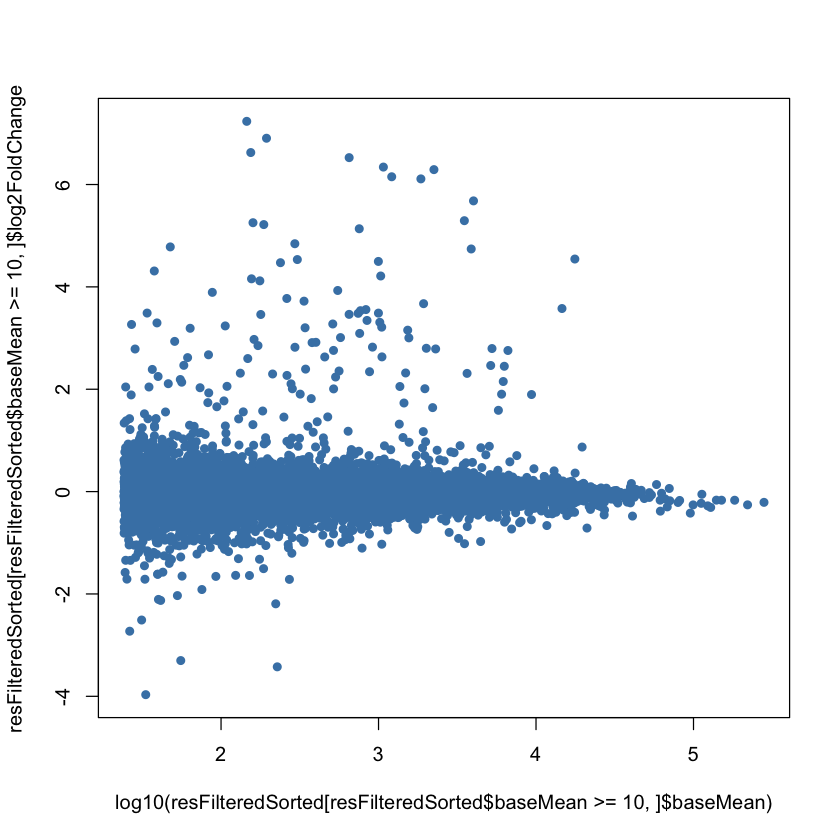

In [123]:
plot(log10(resFilteredSorted[resFilteredSorted$baseMean >= 10,]$baseMean), resFilteredSorted[resFilteredSorted$baseMean >= 10,]$log2FoldChange, pch=16, col=c("steelblue"))


We see in the above plot that DeSeq2 has already excluded a number of genes with low counts from the model.


Let's take a look at the number of genes we are picking as our background and the number of differentially expressed genes.

In [24]:
nrow(resSorted)
nrow(resFilteredSorted)
nrow(resSorted[resSorted$baseMean >=10,])
nrow(resFilteredSorted[abs(resFilteredSorted$log2FoldChange) >= 1 & resFilteredSorted$padj<=0.05,])

[1] 58735

[1] 17084

[1] 19778

[1] 144

In [25]:
resFilteredSorted.up <- resFilteredSorted[resFilteredSorted$log2FoldChange >= 1 & resFilteredSorted$padj<=0.05,]

In [27]:
resFilteredSorted.down <- resFilteredSorted[resFilteredSorted$log2FoldChange <= 1 & resFilteredSorted$padj<=0.05,]

In [26]:
resFilteredSorted.diff <- resFilteredSorted[abs(resFilteredSorted$log2FoldChange) >= 1 & resFilteredSorted$padj<=0.05,]

Let's actually do an enrichment now. We'll use the enrichGo() function from clusterProfiler. 

**Note**: "universe" parameter is actually the background that we pick.

In [56]:
ego.up <- enrichGO(gene = rownames(resFilteredSorted.up),
                universe = rownames(resFilteredSorted),
                OrgDb = org.Hs.eg.db,
                keyType = "ENSEMBL",
                ont = "MF",
                pAdjustMethod = "BH",
                pvalueCutoff  = 0.01,
                qvalueCutoff  = 0.05,
               maxGSSize = 5000,
               minGSSize = 10)

In [48]:
ego.up.cc <- enrichGO(gene = rownames(resFilteredSorted.up),
                universe = rownames(resFilteredSorted),
                OrgDb = org.Hs.eg.db,
                keyType = "ENSEMBL",
                ont = "CC",
                pAdjustMethod = "BH",
                pvalueCutoff  = 0.01,
                qvalueCutoff  = 0.05,
               maxGSSize = 5000,
               minGSSize = 10)

In [32]:
ego.diff <- enrichGO(gene = rownames(resFilteredSorted.diff),
                universe = rownames(resFilteredSorted),
                OrgDb = org.Hs.eg.db,
                keyType = "ENSEMBL",
                ont = "MF",
                pAdjustMethod = "BH",
                pvalueCutoff  = 0.01,
                qvalueCutoff  = 0.05,
               maxGSSize = 5000,
               minGSSize = 10)

In [45]:
ego.down <- enrichGO(gene = rownames(resFilteredSorted.down),
                universe = rownames(resFilteredSorted),
                OrgDb = org.Hs.eg.db,
                keyType = "ENSEMBL",
                ont = "MF",
                pAdjustMethod = "BH",
                pvalueCutoff  = 0.01,
                qvalueCutoff  = 0.05,
               maxGSSize = 5000,
               minGSSize = 10)

In [34]:
head(ego.diff)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
GO:0042605,GO:0042605,peptide antigen binding,7/128,15/12527,5.926920e-11,2.281864e-08,1.790554e-08,ENSG00000206341/ENSG00000204642/ENSG00000168394/ENSG00000204525/ENSG00000234745/ENSG00000204592/ENSG00000206503,7
GO:0003823,GO:0003823,antigen binding,7/128,24/12527,2.953381e-09,5.685259e-07,4.461160e-07,ENSG00000206341/ENSG00000204642/ENSG00000168394/ENSG00000204525/ENSG00000234745/ENSG00000204592/ENSG00000206503,7
GO:0003725,GO:0003725,double-stranded RNA binding,9/128,69/12527,3.091404e-08,3.967302e-06,3.113098e-06,ENSG00000111331/ENSG00000111335/ENSG00000089127/ENSG00000115267/ENSG00000137628/ENSG00000107201/ENSG00000108771/ENSG00000055332/ENSG00000135114,9
GO:0005102,GO:0005102,signaling receptor binding,27/128,1035/12527,4.566462e-06,4.395220e-04,3.448881e-04,ENSG00000115415/ENSG00000188313/ENSG00000128335/ENSG00000206341/ENSG00000271503/ENSG00000090339/ENSG00000204267/ENSG00000172216/ENSG00000135114/ENSG00000204642/ENSG00000168394/ENSG00000162692/ENSG00000111981/ENSG00000186470/ENSG00000204525/ENSG00000234745/ENSG00000108691/ENSG00000111801/ENSG00000204592/ENSG00000169245/ENSG00000026950/ENSG00000081479/ENSG00000206503/ENSG00000128965/ENSG00000125730/ENSG00000110057/ENSG00000128342,27
GO:0042379,GO:0042379,chemokine receptor binding,4/128,16/12527,1.721074e-05,1.274036e-03,9.997222e-04,ENSG00000115415/ENSG00000271503/ENSG00000108691/ENSG00000169245,4
GO:0003727,GO:0003727,single-stranded RNA binding,7/128,82/12527,1.985511e-05,1.274036e-03,9.997222e-04,ENSG00000115267/ENSG00000137628/ENSG00000107201/ENSG00000108771/ENSG00000138035/ENSG00000128016/ENSG00000152778,7


In [30]:
head(ego.up)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
GO:0042605,GO:0042605,peptide antigen binding,7/112,15/12527,2.292109e-11,8.136986e-09,6.466160e-09,ENSG00000206341/ENSG00000204642/ENSG00000168394/ENSG00000204525/ENSG00000234745/ENSG00000204592/ENSG00000206503,7
GO:0003823,GO:0003823,antigen binding,7/112,24/12527,1.153776e-09,2.047952e-07,1.627431e-07,ENSG00000206341/ENSG00000204642/ENSG00000168394/ENSG00000204525/ENSG00000234745/ENSG00000204592/ENSG00000206503,7
GO:0003725,GO:0003725,double-stranded RNA binding,9/112,69/12527,9.550670e-09,1.130163e-06,8.980981e-07,ENSG00000111331/ENSG00000111335/ENSG00000089127/ENSG00000115267/ENSG00000137628/ENSG00000107201/ENSG00000108771/ENSG00000055332/ENSG00000135114,9
GO:0005102,GO:0005102,signaling receptor binding,26/112,1035/12527,1.023411e-06,9.082775e-05,7.217742e-05,ENSG00000115415/ENSG00000188313/ENSG00000128335/ENSG00000206341/ENSG00000271503/ENSG00000090339/ENSG00000204267/ENSG00000172216/ENSG00000135114/ENSG00000204642/ENSG00000168394/ENSG00000162692/ENSG00000111981/ENSG00000186470/ENSG00000204525/ENSG00000234745/ENSG00000108691/ENSG00000111801/ENSG00000204592/ENSG00000169245/ENSG00000026950/ENSG00000206503/ENSG00000128965/ENSG00000125730/ENSG00000110057/ENSG00000128342,26
GO:0003727,GO:0003727,single-stranded RNA binding,7/112,82/12527,8.275750e-06,5.875783e-04,4.669265e-04,ENSG00000115267/ENSG00000137628/ENSG00000107201/ENSG00000108771/ENSG00000138035/ENSG00000128016/ENSG00000152778,7
GO:0042379,GO:0042379,chemokine receptor binding,4/112,16/12527,1.014415e-05,6.001953e-04,4.769528e-04,ENSG00000115415/ENSG00000271503/ENSG00000108691/ENSG00000169245,4


In [49]:
head(ego.up.cc)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
GO:0042611,GO:0042611,MHC protein complex,7/114,11/13044,1.036538e-12,2.684634e-10,2.302206e-10,ENSG00000206341/ENSG00000204642/ENSG00000204525/ENSG00000166710/ENSG00000234745/ENSG00000204592/ENSG00000206503,7
GO:0030670,GO:0030670,phagocytic vesicle membrane,9/114,58/13044,1.608587e-09,2.083120e-07,1.786378e-07,ENSG00000206341/ENSG00000204267/ENSG00000204642/ENSG00000168394/ENSG00000204525/ENSG00000166710/ENSG00000234745/ENSG00000204592/ENSG00000206503,9
GO:0071556,GO:0071556,integral component of lumenal side of endoplasmic reticulum membrane,6/114,19/13044,9.652749e-09,6.250155e-07,5.359816e-07,ENSG00000206341/ENSG00000204642/ENSG00000204525/ENSG00000234745/ENSG00000204592/ENSG00000206503,6
GO:0098553,GO:0098553,lumenal side of endoplasmic reticulum membrane,6/114,19/13044,9.652749e-09,6.250155e-07,5.359816e-07,ENSG00000206341/ENSG00000204642/ENSG00000204525/ENSG00000234745/ENSG00000204592/ENSG00000206503,6
GO:0045335,GO:0045335,phagocytic vesicle,10/114,98/13044,1.282385e-08,6.642754e-07,5.696489e-07,ENSG00000206341/ENSG00000204267/ENSG00000204642/ENSG00000168394/ENSG00000204525/ENSG00000166710/ENSG00000234745/ENSG00000204592/ENSG00000206503/ENSG00000110057,10
GO:0012507,GO:0012507,ER to Golgi transport vesicle membrane,7/114,49/13044,2.052364e-07,8.859370e-06,7.597346e-06,ENSG00000206341/ENSG00000204642/ENSG00000204525/ENSG00000166710/ENSG00000234745/ENSG00000204592/ENSG00000206503,7


Now, let's create a plot to visualize these GO categories. Let's use the built in dotplot() function formclusterProfiler

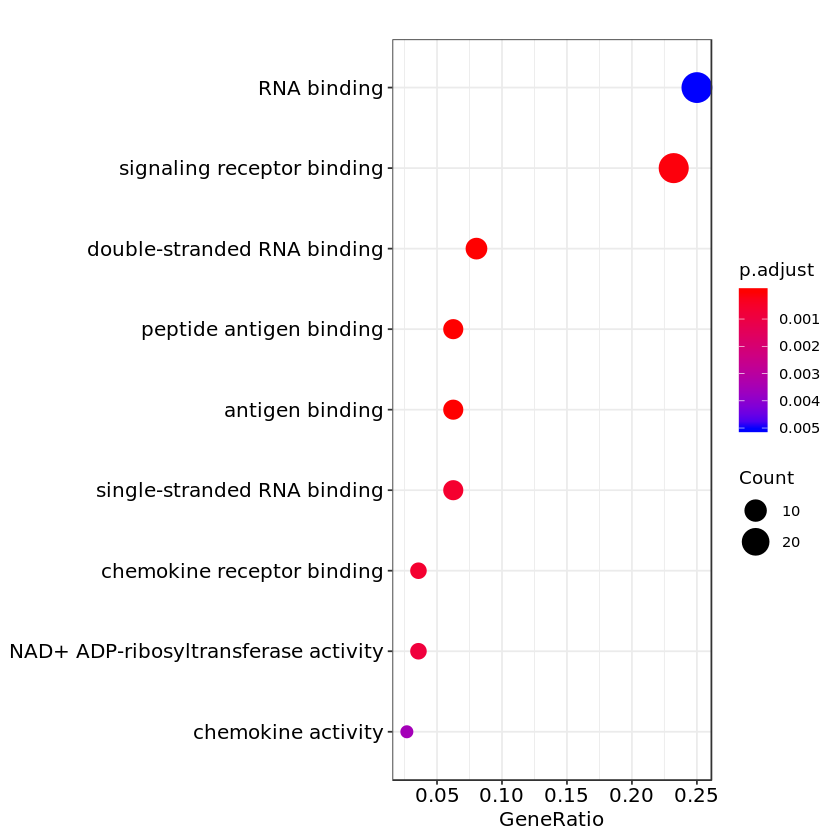

In [57]:
dotplot(ego.up, showCategory=15)

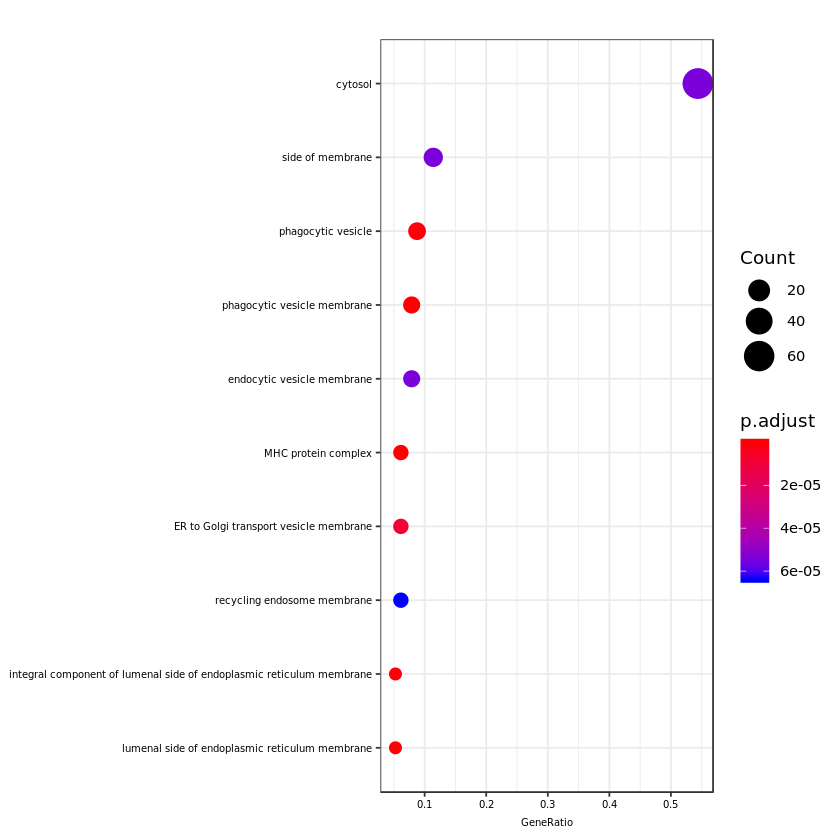

In [53]:
dotplot(ego.up.cc, showCategory=10, font.size=6)

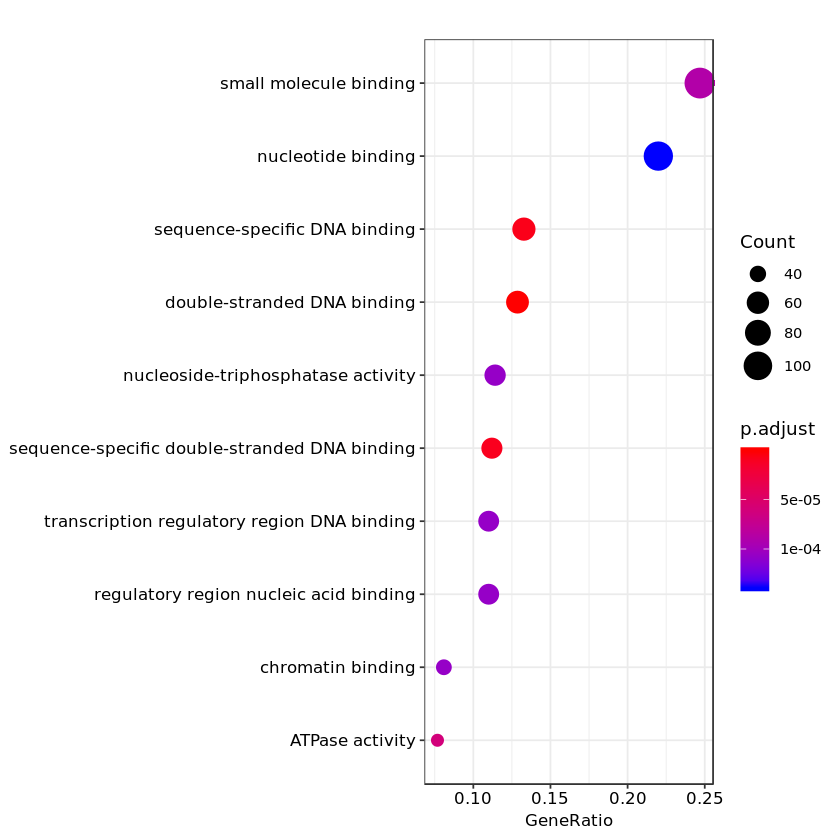

In [47]:
dotplot(ego.down, showCategory=10, font.size=10)

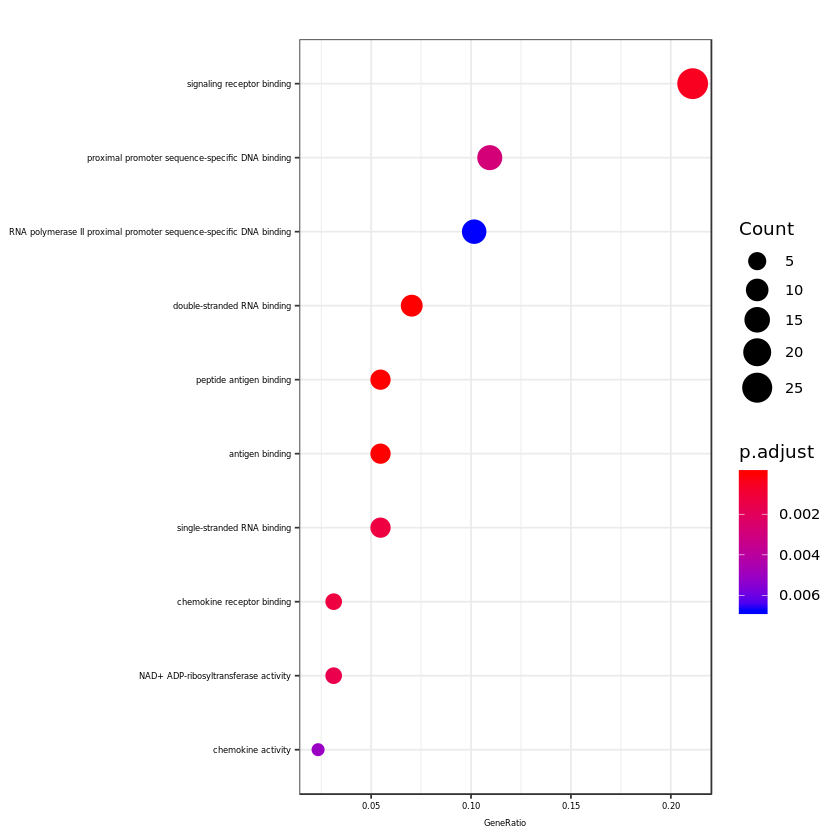

In [44]:
dotplot(ego.diff, font.size=5)